In [ ]:
!pip install segmentation-models
!pip install tensorflow==2.1.0
!pip install keras==2.3.1

     |████████████████████████████████| 50 kB 6.1 MB/s 
     |████████████████████████████████| 421.8 MB 23 kB/s 
     |████████████████████████████████| 3.8 MB 41.5 MB/s 
     |████████████████████████████████| 448 kB 54.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=fd60421cf2836df7769f91ae648f08e5971d592d9538294e6138f31732d30e7e
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

In [ ]:
!pip install livelossplot
%matplotlib inline

In [ ]:
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
import tensorflow as tf
import segmentation_models as sm
BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#print(os.listdir("membrane/train"))

#Resizing images is optional, CNNs are ok with large images
SIZE_X = 128 #Resize images (height  = X, width = Y)
SIZE_Y = 128

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("/content/A3_Dataset/dataset1/annotations_prepped_train"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("/content/A3_Dataset/dataset1/images_prepped_train"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        mask=mask.astype(np.float)
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [ ]:
#Use customary x_train and y_train variables
X = train_images
Y = train_masks
#Y = np.expand_dims(Y, axis=3) #May not be necessary.. leftover from previous code 


from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

In [ ]:
sm.set_framework('tf.keras')


In [ ]:
!pip uninstall h5py
!pip install h5py==2.10.0

Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/h5py-3.1.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libaec-9c9e97eb.so.0.0.10
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5-00e8fae8.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5_hl-383c339f.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libsz-e7aa62f5.so.2.0.1
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libz-eb09ad1d.so.1.2.3
    /usr/local/lib/python3.7/dist-packages/h5py/*
Proceed (y/n)? y
  Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 2.9 MB 5.2 MB/s 


In [ ]:
sm.Unet()
'''model = sm.Unet(input_shape= BACKBONE, encoder_weights='imagenet')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])'''

model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score],)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [ ]:
history =model.fit(
   x=x_train,
   y=y_train,
   batch_size=32,
   epochs=10,
   verbose=1,
   validation_data=(x_val, y_val),
)
model.save("backbone_vgg")

Train on 293 samples, validate on 74 samples
Epoch 1/10
293/293 [==============================] - 279s 951ms/sample - loss: -89.4631 - iou_score: 2.1164 - val_loss: -618.3067 - val_iou_score: 21.5214
Epoch 2/10
293/293 [==============================] - 274s 934ms/sample - loss: -212.8922 - iou_score: 3.6071 - val_loss: -1743.0625 - val_iou_score: 105.0839
Epoch 3/10
293/293 [==============================] - 273s 932ms/sample - loss: -341.7074 - iou_score: 3.7168 - val_loss: -1786.7707 - val_iou_score: 113.1740
Epoch 4/10
293/293 [==============================] - 275s 939ms/sample - loss: -501.7727 - iou_score: 3.3022 - val_loss: -1791.9138 - val_iou_score: 113.4459
Epoch 5/10
293/293 [==============================] - 274s 934ms/sample - loss: -623.9606 - iou_score: 3.5596 - val_loss: -1792.0332 - val_iou_score: 113.4459
Epoch 6/10
293/293 [==============================] - 274s 935ms/sample - loss: -738.0672 - iou_score: 4.3440 - val_loss: -1792.0349 - val_iou_score: 113.4459
Epoc

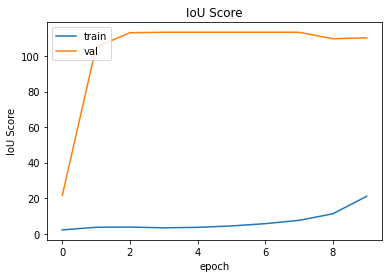

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('IoU Score')
plt.ylabel('IoU Score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

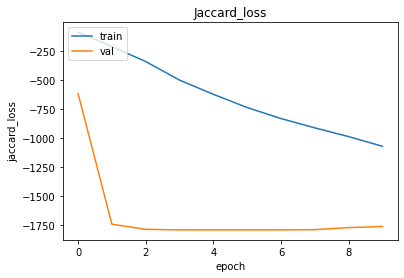

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Jaccard_loss')
plt.ylabel('jaccard_loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()